<a href="https://colab.research.google.com/github/JihyeLimm/Quest/blob/main/Going_Deeper_NLP/node9/gd_node9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#9. 임베딩 내 편향성 알아보기
1. 주어진 영화 코퍼스를 바탕으로 워드임베딩 모델을 정상적으로 만들었다.
>워드임베딩의 most_similar() 메소드 결과가 의미상 바르게 나왔다.
2. 영화 구분, 장르별로 target, attribute에 대한 대표성있는 단어 셋을 생성하였다.
>타당한 방법론을 통해 중복이 잘 제거되고 개념축을 의미적으로 잘 대표하는 단어 셋이 만들어졌다.
3. WEAT score 계산 및 시각화를 정상적으로 진행하였다.
>전체 영화 장르별로 예술/일반 영화에 대한 편향성 WEAT score가 상식에 부합하는 수치로 얻어졌으며 이를 잘 시각화하였다.

In [ ]:
import os
from google.colab import drive
drive.mount('/gdrive', force_remount = True)
os.chdir("/gdrive/MyDrive/AIFFEL/230629")
os.getcwd()

Mounted at /gdrive


'/gdrive/MyDrive/AIFFEL/230629'

In [ ]:
!pip install konlpy

In [ ]:
import numpy as np
import pandas as pd
from numpy import dot
from numpy.linalg import norm

from konlpy.tag import Okt
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

from sklearn.decomposition import LatentDirichletAllocation

import seaborn as sns
#import matplotlib.pyplot as plt
#%matplotlib inline

STEP 1. 형태소 분석기를 이용하여 품사가 명사인 경우 해당 단어를 추출하기

In [ ]:
#synopsis.txt 파일을 읽어 품사가 명사인 경우만 남겨 tokenized라는 변수명으로 저장
okt = Okt()
tokenized = []
with open('synopsis.txt', 'r') as file:
    while True:
        line = file.readline()
        if not line: break
        words = okt.pos(line, stem=True, norm=True)
        res = []
        for w in words:
            if w[1] in ["Noun"]:      # "Adjective", "Verb" 등을 포함할 수도 있음
                res.append(w[0])    # 명사일 때만 tokenized 에 저장
        tokenized.append(res)

print(len(tokenized))
tokenized[:5]

71156


[['사운드', '엔지니어', '상우', '유지태', '분', '치매', '할머니', '백성희', '분'],
 ['시절', '상처', '아버지', '박인환', '분', '고모', '신신애', '분', '살'],
 ['겨울', '그', '지방', '방송국', '라디오', '은수', '이영애', '분', '를'],
 ['자연', '소리', '채집', '라디오', '프로그램', '준비', '은수', '상우', '녹음', '여행'],
 ['두', '사람', '날', '은수', '아파트', '밤']]

STEP 2. 추출된 결과로 embedding model 만들기

In [ ]:
# tokenized에 담긴 데이터를 가지고 나만의 Word2Vec을 생성합니다. (Gensim 4.0 기준)
model = Word2Vec(tokenized, vector_size=100, window=5, min_count=3, sg=0)
model.wv.most_similar(positive=['기술'])

[('실험', 0.8985767960548401),
 ('효과', 0.8917192816734314),
 ('시스템', 0.8825318813323975),
 ('에너지', 0.8803293108940125),
 ('제공', 0.8790849447250366),
 ('활용', 0.8747705817222595),
 ('사용', 0.8731818199157715),
 ('미디어', 0.8694151639938354),
 ('창조', 0.86156165599823),
 ('유전자', 0.8606051802635193)]

STEP 3. target, attribute 단어 셋 만들기
- 예술영화와 일반영화(상업영화)라는 영화구분을 target
- 드라마 장르와 액션 장르라는 장르구분을 attribute

[TFIDF의 한계]
>TFIDF는 개별 문서에서 단어의 빈도수와 문서 전체에서의 등장 빈도수를 고려하기 때문에 다른 문서를 고려한 전체적인 개념축 반영이 어려움 -> 중복단어 발생

>한 단어가 여러 개념을 포함하거나 여러 개념과 연결될 수 있는데 이런 다의성문제를 해결하기 어려움

>sparse matrix의 한계가짐

1. Target

In [ ]:
#data load
art_txt = 'synopsis_art.txt'
gen_txt = 'synopsis_gen.txt'

def read_token(file_name):
    okt = Okt()
    result = []
    with open(file_name, 'r') as fread:
        print(file_name, '파일을 읽고 있습니다.')
        while True:
            line = fread.readline()
            if not line: break
            tokenlist = okt.pos(line, stem=True, norm=True)
            for word in tokenlist:
                if word[1] in ["Noun"]:#, "Adjective", "Verb"]:
                    result.append((word[0]))
    return ' '.join(result)

art = read_token(art_txt)
gen = read_token(gen_txt)

synopsis_art.txt 파일을 읽고 있습니다.
synopsis_gen.txt 파일을 읽고 있습니다.


'사운드'

In [ ]:
#전처리 끝난 str저장
f = open("art.txt", 'w')
f.write(str(art))
f.close()

f = open("gen.txt", 'w')
f.write(str(gen))
f.close()

print(art[:100], "\n")
print(gen[:100])

사운드 엔지니어 상우 유지태 분 치매 할머니 백성희 분 시절 상처 아버지 박인환 분 고모 신신애 분 살 겨울 그 지방 방송국 라디오 은수 이영애 분 를 자연 소리 채집 라디오 프로 

유사 연령 성별 빈부 차이 정치 입장 불문 국민 통합 온 애국심 성역 일침 다큐멘터리 재작년 전국 민족 민주 유가족 협의 회의 장기 농성 인상 다큐멘터리 민들레 를 독립영화 집단 


In [ ]:
#vertorizing
def vecto(corpus):
  tokens = corpus.split()# 단어 토큰화
  vectorizer = CountVectorizer() # CountVectorizer를 이용하여 DTM 생성
  dtm = vectorizer.fit_transform(tokens)

  lda_model = LatentDirichletAllocation(n_components=5, random_state=0) # LDA 모델 학습
  lda_model.fit(dtm)

  topic_word_distributions = lda_model.components_
  word_index = vectorizer.get_feature_names_out()
  topics = [dict(zip(word_index, topic_dist)) for topic_dist in topic_word_distributions] # 학습된 LDA 모델을 통해 토픽-단어 분포 추출

  representative_words = []
  for topic in topics: # 대표단어 100개 추출
      sorted_words = sorted(topic.items(), key=lambda x: x[1], reverse=True)[:20]
      representative_words.extend([word for word, _ in sorted_words])

  return representative_words

In [ ]:
w1_ = vecto(art)
w2_ = vecto(gen)
print("예술: ", w1_)
print("일반: ", w2_)

예술:  ['자신', '시작', '위해', '사랑', '이야기', '마을', '사건', '아이', '시간', '소녀', '아내', '여행', '발견', '비밀', '학교', '음악', '소년', '도시', '때문', '최고', '영화', '여자', '대한', '다른', '사실', '모두', '순간', '죽음', '한편', '위기', '이자', '과거', '상황', '미국', '만난', '처음', '가지', '상처', '목숨', '이유', '사람', '마음', '엄마', '모든', '서로', '아들', '영화제', '세계', '가장', '아빠', '생활', '이제', '현실', '지금', '단편', '여인', '준비', '국제', '동안', '존재', '그녀', '친구', '가족', '세상', '다시', '사이', '하나', '점점', '감독', '우리', '모습', '생각', '명의', '사고', '전쟁', '경찰', '간다', '이후', '충격', '어머니', '남자', '아버지', '과연', '남편', '인생', '마지막', '통해', '기억', '결혼', '결심', '운명', '이름', '인간', '누구', '계속', '할머니', '제안', '거리', '무엇', '바로']
일반:  ['시작', '국제', '이야기', '대한', '다른', '아들', '모든', '단편', '세계', '아내', '소녀', '사이', '소년', '여행', '학교', '미국', '동안', '바로', '이후', '부산', '영화제', '남자', '가족', '모습', '발견', '하나', '여성', '죽음', '상황', '기억', '간다', '가지', '경찰', '주인공', '존재', '살인', '한국', '회사', '문제', '로부터', '사람', '친구', '사랑', '서울', '여자', '마을', '마음', '사실', '다시', '서로', '감독', '때문', '생활', '가장', '순간', '이제', '도시', '이자', '마지막', '현실', '그녀', '영화', '아이',

In [ ]:
# w1에만 있고 w2에는 없는, 예술영화를 잘 대표하는 단어를 15개 추출
#w1_ = ['자신', '시작', '위해', '사랑', '이야기', '마을', '사건', '아이', '시간', '소녀', '아내', '여행', '발견', '비밀', '학교', '음악', '소년', '도시', '때문', '최고', '영화', '여자', '대한', '다른', '사실', '모두', '순간', '죽음', '한편', '위기', '이자', '과거', '상황', '미국', '만난', '처음', '가지', '상처', '목숨', '이유', '사람', '마음', '엄마', '모든', '서로', '아들', '영화제', '세계', '가장', '아빠', '생활', '이제', '현실', '지금', '단편', '여인', '준비', '국제', '동안', '존재', '그녀', '친구', '가족', '세상', '다시', '사이', '하나', '점점', '감독', '우리', '모습', '생각', '명의', '사고', '전쟁', '경찰', '간다', '이후', '충격', '어머니', '남자', '아버지', '과연', '남편', '인생', '마지막', '통해', '기억', '결혼', '결심', '운명', '이름', '인간', '누구', '계속', '할머니', '제안', '거리', '무엇', '바로']
#w2_ = ['시작', '국제', '이야기', '대한', '다른', '아들', '모든', '단편', '세계', '아내', '소녀', '사이', '소년', '여행', '학교', '미국', '동안', '바로', '이후', '부산', '영화제', '남자', '가족', '모습', '발견', '하나', '여성', '죽음', '상황', '기억', '간다', '가지', '경찰', '주인공', '존재', '살인', '한국', '회사', '문제', '로부터', '사람', '친구', '사랑', '서울', '여자', '마을', '마음', '사실', '다시', '서로', '감독', '때문', '생활', '가장', '순간', '이제', '도시', '이자', '마지막', '현실', '그녀', '영화', '아이', '엄마', '인간', '모두', '비밀', '과거', '대해', '사고', '섹스', '위기', '계획', '조직', '부부', '무엇', '할머니', '혼자', '이상', '만난', '자신', '위해', '사건', '남편', '아버지', '시간', '작품', '통해', '생각', '세상', '관계', '우리', '애니메이션', '과연', '점점', '한편', '결혼', '명의', '전쟁', '연출']

n = 15
target_art, target_gen = [], []
for i in range(100):
    if (w1_[i] not in w2_) and (w1_[i] in model.wv): target_art.append(w1_[i])
    if len(target_art) == n: break

# w2에만 있고 w1에는 없는, 일반영화를 잘 대표하는 단어를 15개 추출
for i in range(100):
    if (w2_[i] not in w1_) and (w2_[i] in model.wv): target_gen.append(w2_[i])
    if len(target_gen) == n: break

print(target_art)
print(target_gen)

['음악', '최고', '처음', '상처', '목숨', '이유', '아빠', '지금', '여인', '준비', '충격', '어머니', '인생', '결심', '운명']
['부산', '여성', '주인공', '살인', '한국', '회사', '문제', '로부터', '서울', '대해', '섹스', '계획', '조직', '부부', '혼자']


2. Attribute

In [ ]:
#data load
genre_txt = ['synopsis_SF.txt', 'synopsis_family.txt', 'synopsis_show.txt', 'synopsis_horror.txt', 'synopsis_etc.txt',
             'synopsis_documentary.txt', 'synopsis_drama.txt', 'synopsis_romance.txt', 'synopsis_musical.txt',
             'synopsis_mystery.txt', 'synopsis_crime.txt', 'synopsis_historical.txt', 'synopsis_western.txt',
             'synopsis_adult.txt', 'synopsis_thriller.txt', 'synopsis_animation.txt', 'synopsis_action.txt',
             'synopsis_adventure.txt', 'synopsis_war.txt', 'synopsis_comedy.txt', 'synopsis_fantasy.txt']
genre_name = ['SF', '가족', '공연', '공포(호러)', '기타', '다큐멘터리', '드라마', '멜로로맨스', '뮤지컬', '미스터리', '범죄', '사극', '서부극(웨스턴)',
         '성인물(에로)', '스릴러', '애니메이션', '액션', '어드벤처', '전쟁', '코미디', '판타지']

genre = []
for file_name in genre_txt:
    genre.append(read_token(file_name))

synopsis_SF.txt 파일을 읽고 있습니다.
synopsis_family.txt 파일을 읽고 있습니다.
synopsis_show.txt 파일을 읽고 있습니다.
synopsis_horror.txt 파일을 읽고 있습니다.
synopsis_etc.txt 파일을 읽고 있습니다.
synopsis_documentary.txt 파일을 읽고 있습니다.
synopsis_drama.txt 파일을 읽고 있습니다.
synopsis_romance.txt 파일을 읽고 있습니다.
synopsis_musical.txt 파일을 읽고 있습니다.
synopsis_mystery.txt 파일을 읽고 있습니다.
synopsis_crime.txt 파일을 읽고 있습니다.
synopsis_historical.txt 파일을 읽고 있습니다.
synopsis_western.txt 파일을 읽고 있습니다.
synopsis_adult.txt 파일을 읽고 있습니다.
synopsis_thriller.txt 파일을 읽고 있습니다.
synopsis_animation.txt 파일을 읽고 있습니다.
synopsis_action.txt 파일을 읽고 있습니다.
synopsis_adventure.txt 파일을 읽고 있습니다.
synopsis_war.txt 파일을 읽고 있습니다.
synopsis_comedy.txt 파일을 읽고 있습니다.
synopsis_fantasy.txt 파일을 읽고 있습니다.


In [ ]:
#각 장르를 대표하는 단어들을 추출
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(genre)

m = [X[i].tocoo() for i in range(X.shape[0])]

w = [[[i, j] for i, j in zip(mm.col, mm.data)] for mm in m]

for i in range(len(w)):
    w[i].sort(key=lambda x: x[1], reverse=True)
attributes = []


#각 장르를 대표하는 단어들을 추출
for i in range(len(w)):
    print(genre_name[i], end=': ')
    attr = []
    j = 0
    while (len(attr) < 15):
        if vectorizer.get_feature_names_out()[w[i][j][0]] in model.wv:
            attr.append(vectorizer.get_feature_names_out()[w[i][j][0]])
            print(vectorizer.get_feature_names_out()[w[i][j][0]], end=', ')
        j += 1
    attributes.append(attr)
    print()

SF: 위해, 자신, 지구, 시작, 사람, 인류, 인간, 미래, 우주, 그녀, 로봇, 세계, 모든, 박사, 우주선, 
가족: 엄마, 아빠, 가족, 영화제, 자신, 위해, 친구, 아주르, 아버지, 시작, 그녀, 아들, 마을, 국제, 낙타, 
공연: 오페라, 사랑, 토스카, 실황, 올레, 자신, 카바, 그녀, 공연, 오텔로, 리골레토, 백작, 프레, 베르디, 위해, 
공포(호러): 시작, 위해, 사람, 자신, 친구, 그녀, 사건, 공포, 발견, 죽음, 마을, 가족, 악령, 남자, 좀비, 
기타: 영화제, 국제, 서울, 단편, 영화, 자신, 사람, 이야기, 그녀, 남자, 위해, 시작, 사랑, 뉴미디어, 페스티벌, 
다큐멘터리: 영화제, 영화, 다큐, 국제, 다큐멘터리, 사람, 이야기, 대한, 자신, 감독, 위해, 서울, 우리, 시작, 세계, 
드라마: 자신, 영화제, 그녀, 사람, 사랑, 영화, 위해, 시작, 국제, 남자, 친구, 이야기, 엄마, 여자, 아버지, 
멜로로맨스: 그녀, 사랑, 자신, 시작, 남편, 남자, 여자, 사람, 친구, 섹스, 위해, 마음, 결혼, 서로, 아내, 
뮤지컬: 뮤지컬, 사랑, 에스메랄다, 그녀, 음악, 충무로, 모차르트, 영화, 토스카, 자신, 니웨, 카바, 영화제, 바흐, 페뷔스, 
미스터리: 사건, 그녀, 시작, 자신, 위해, 사람, 발견, 사고, 진실, 죽음, 기억, 살인, 친구, 아내, 남자, 
범죄: 사건, 위해, 자신, 경찰, 시작, 그녀, 범죄, 조직, 살인, 사람, 마약, 형사, 남자, 모든, 살해, 
사극: 조선, 위해, 시작, 신기전, 사랑, 자신, 아가멤논, 황제, 그녀, 루안, 최고, 운명, 사람, 하선, 전쟁, 
서부극(웨스턴): 서부, 보안관, 위해, 벌린, 카우보이, 그레이프바인, 헨리, 마을, 자신, 개릿, 아이, 시작, 무법자, 프린트, 마적, 
성인물(에로): 그녀, 남편, 마사지, 자신, 섹스, 관계, 영화, 정사, 남자, 위해, 시작, 여자, 유부녀, 마음, 사랑, 
스릴러: 자신, 그녀, 사건, 

STEP 4. WEAT score 계산과 시각화

In [ ]:
#관련 함수 선언
def cos_sim(i, j):
    return dot(i, j.T)/(norm(i)*norm(j))

def s(w, A, B):
    c_a = cos_sim(w, A)
    c_b = cos_sim(w, B)
    mean_A = np.mean(c_a, axis=-1)
    mean_B = np.mean(c_b, axis=-1)
    return mean_A - mean_B #, c_a, c_b

def weat_score(X, Y, A, B):

    s_X = s(X, A, B)
    s_Y = s(Y, A, B)

    mean_X = np.mean(s_X)
    mean_Y = np.mean(s_Y)

    std_dev = np.std(np.concatenate([s_X, s_Y], axis=0))

    return  (mean_X-mean_Y)/std_dev

In [ ]:
#WEAT score 계산
matrix = [[0 for _ in range(len(genre_name))] for _ in range(len(genre_name))]

X = np.array([model.wv[word] for word in target_art])
Y = np.array([model.wv[word] for word in target_gen])

for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        A = np.array([model.wv[word] for word in attributes[i]])
        B = np.array([model.wv[word] for word in attributes[j]])
        matrix[i][j] = weat_score(X, Y, A, B)

for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        print(genre_name[i], genre_name[j],matrix[i][j])

SF 가족 0.19460104
SF 공연 0.21824183
SF 공포(호러) 0.25475037
SF 기타 0.61989075
SF 다큐멘터리 0.49980566
SF 드라마 0.25943765
SF 멜로로맨스 0.10132297
SF 뮤지컬 0.41400725
SF 미스터리 0.21832082
SF 범죄 0.7340775
SF 사극 -0.10374234
SF 서부극(웨스턴) 0.41617236
SF 성인물(에로) 0.2946446
SF 스릴러 0.44809332
SF 애니메이션 0.5533117
SF 액션 0.48426032
SF 어드벤처 -0.18814969
SF 전쟁 0.66725016
SF 코미디 0.40093842
SF 판타지 0.19922748
가족 공연 -0.03970632
가족 공포(호러) 0.017091526
가족 기타 0.4971695
가족 다큐멘터리 0.31059197
가족 드라마 0.104678676
가족 멜로로맨스 -0.07094141
가족 뮤지컬 0.25052136
가족 미스터리 0.029690638
가족 범죄 0.44151607
가족 사극 -0.29946327
가족 서부극(웨스턴) 0.16056158
가족 성인물(에로) 0.23123609
가족 스릴러 0.27879688
가족 애니메이션 0.45676774
가족 액션 0.16765937
가족 어드벤처 -0.66995484
가족 전쟁 0.1711814
가족 코미디 0.20754418
가족 판타지 -0.054407027
공연 공포(호러) 0.044383645
공연 기타 0.8074293
공연 다큐멘터리 0.45344293
공연 드라마 0.16845499
공연 멜로로맨스 -0.032819983
공연 뮤지컬 0.46742815
공연 미스터리 0.051093966
공연 범죄 0.4675722
공연 사극 -0.49683613
공연 서부극(웨스턴) 0.17642234
공연 성인물(에로) 0.27293685
공연 스릴러 0.2695874
공연 애니메이션 0.6116557
공연 액션 0.189159

<Axes: >

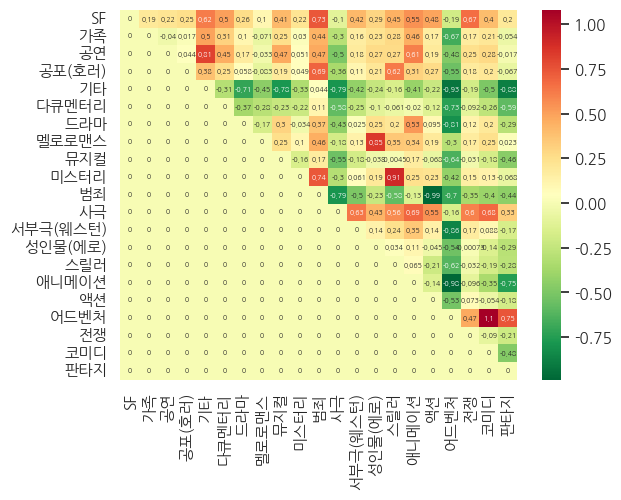

In [99]:
np.random.seed(0)

fe = fm.FontEntry(
    fname=r'NanumGothic.ttf', # path to .ttf
    name='nanum')                        # what you want to name that font
fm.fontManager.ttflist.insert(0, fe)              # add the font to Matplotlib
plt.rcParams.update({'font.size': 5, 'font.family': 'nanum'}) # set the font

plt.rcParams['axes.unicode_minus'] = False

ax = sns.heatmap(matrix, xticklabels=genre_name, yticklabels=genre_name, annot=True,  cmap='RdYlGn_r')
ax